Work flow
1. Xử lý dữ liệu
 - Scale dữ liệu bằng RobustScaler
 - Chuyển đổi cột 'time' sang định dạng datetime
 - Xử lý các giá trị thiếu (nếu có)
 - Dùng biến trễ Lag features: dữ liệu thời tiết của các giờ trước đó để dự đoán giờ hiện tại, ngày hôm trước để dự đoán ngày hôm nay,...
 - Dùng Rolling Mean/Median/Max/Min/Std: tính toán các giá trị trung bình/trung vị/lớn nhất/nhỏ nhất/độ lệch chuẩn trong một khoảng thời gian cố định để làm mượt dữ liệu và giảm nhiễu. Giúp mô hình học được xu hướng dài hạn trong dữ liệu thời tiết.
2. Chia dữ liệu thành train, val, test (70%, 20%, 10%)
3. Sử dụng mô hình AdaBoost, Softmax Regresssion
RamdomForest train trên tập train, tinh chỉnh hyperparameter trên tập val
4. Trực quan hóa kết quả huấn luyện
5. Đánh giá mô hình bằng accuracy, precision, recall, F1-score, confusion matrix, Cohen's Kappa, Confusion Matrix Heatmap
6. So sánh kết quả giữa các mô hình

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler

In [9]:
# ================== BƯỚC 1: LOAD & KIỂM TRA DỮ LIỆU ==================
data = pd.read_csv('DNWeather.csv')
print("Shape:", data.shape)
print("\nInfo:")
data.info()
print("\nMissing values:")
print(data.isnull().sum())
data.head()

Shape: (8880, 8)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8880 entries, 0 to 8879
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   time                      8880 non-null   object 
 1   temperature_2m (°C)       8880 non-null   float64
 2   weather_code (wmo code)   8880 non-null   int64  
 3   relative_humidity_2m (%)  8880 non-null   int64  
 4   surface_pressure (hPa)    8880 non-null   float64
 5   wind_speed_10m (km/h)     8880 non-null   float64
 6   wind_direction_10m (°)    8880 non-null   int64  
 7   cloud_cover (%)           8880 non-null   int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 555.1+ KB

Missing values:
time                        0
temperature_2m (°C)         0
weather_code (wmo code)     0
relative_humidity_2m (%)    0
surface_pressure (hPa)      0
wind_speed_10m (km/h)       0
wind_direction_10m (°)      0
cloud_cover (%)             0

,time,temperature_2m (°C),weather_code (wmo code),relative_humidity_2m (%),surface_pressure (hPa),wind_speed_10m (km/h),wind_direction_10m (°),cloud_cover (%)
0,2025-01-01T00:00,20.1,2,90,1016.1,3.8,295,65
1,2025-01-01T01:00,19.8,2,92,1015.4,4.4,291,72
2,2025-01-01T02:00,19.2,2,94,1014.5,5.0,285,53
3,2025-01-01T03:00,18.8,3,94,1014.1,3.7,284,91
4,2025-01-01T04:00,18.7,1,94,1013.9,2.8,288,42


In [10]:
# ================== BƯỚC 2: CHUYỂN ĐỔI DATETIME ==================
data['time'] = pd.to_datetime(data['time'])

# Trích xuất các đặc trưng thời gian
data['hour'] = data['time'].dt.hour
data['day'] = data['time'].dt.day
data['month'] = data['time'].dt.month
data['day_of_week'] = data['time'].dt.dayofweek
data['day_of_year'] = data['time'].dt.dayofyear

# Cyclic encoding cho hour và month
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

In [11]:
# ================== BƯỚC 3: XỬ LÝ GIÁ TRỊ THIẾU ==================
# Kiểm tra lại missing values
print("\nMissing values after datetime conversion:")
print(data.isnull().sum())

# Xử lý missing (nếu có)
# data = data.fillna(method='ffill')  # Forward fill
# hoặc
# data = data.dropna()


Missing values after datetime conversion:
time                        0
temperature_2m (°C)         0
weather_code (wmo code)     0
relative_humidity_2m (%)    0
surface_pressure (hPa)      0
wind_speed_10m (km/h)       0
wind_direction_10m (°)      0
cloud_cover (%)             0
hour                        0
day                         0
month                       0
day_of_week                 0
day_of_year                 0
hour_sin                    0
hour_cos                    0
month_sin                   0
month_cos                   0
dtype: int64


In [12]:
# ================== BƯỚC 4: SẮP XẾP THEO THỜI GIAN ==================
data = data.sort_values('time').reset_index(drop=True)

In [14]:
# ================== BƯỚC 5: TẠO LAG FEATURES ==================
numeric_features = ['temperature_2m (°C)', 'relative_humidity_2m (%)', 
                   'surface_pressure (hPa)', 'wind_speed_10m (km/h)', 
                   'wind_direction_10m (°)', 'cloud_cover (%)']

# Lag 1, 3, 6 giờ trước, 1 ngày trước (24 giờ)
for col in numeric_features:
    data[f'{col}_lag1'] = data[col].shift(1)
    data[f'{col}_lag3'] = data[col].shift(3)
    data[f'{col}_lag6'] = data[col].shift(6)
    data[f'{col}_lag24'] = data[col].shift(24)  

In [15]:
# ================== BƯỚC 6: ROLLING STATISTICS ==================
# Rolling mean, max, min, std cho 3 giờ
for col in numeric_features:
    data[f'{col}_rolling_mean_3h'] = data[col].rolling(window=3).mean()
    data[f'{col}_rolling_max_3h'] = data[col].rolling(window=3).max()
    data[f'{col}_rolling_min_3h'] = data[col].rolling(window=3).min()
    data[f'{col}_rolling_std_3h'] = data[col].rolling(window=3).std()

# Rolling cho 6 giờ
for col in numeric_features:
    data[f'{col}_rolling_mean_6h'] = data[col].rolling(window=6).mean()

In [31]:
# ================== BƯỚC 7: XÓA NaN SAU SHIFT & ROLLING ==================
print(f"\nShape before dropna: {data.shape}")
data = data.dropna()
print(f"Shape after dropna: {data.shape}")
data = data.drop(columns=['time'])  # Loại bỏ cột time nếu không cần thiết


Shape before dropna: (8856, 71)
Shape after dropna: (8856, 71)


In [32]:
# ================== BƯỚC 8: ROBUST SCALER ==================
# Lấy tất cả numeric columns (trừ target)
feature_cols = [col for col in data.columns 
                if col not in ['time', 'weather_code (wmo code)', 
                              'hour', 'day', 'month', 'day_of_week', 'day_of_year']]

robust_scaler = RobustScaler()
data_scaled = data.copy()
data_scaled[feature_cols] = robust_scaler.fit_transform(data[feature_cols])

In [33]:
# ================== BƯỚC 10: KIỂM TRA KẾT QUẢ ==================
data_scaled.head()

,temperature_2m (°C),weather_code (wmo code),relative_humidity_2m (%),surface_pressure (hPa),wind_speed_10m (km/h),wind_direction_10m (°),cloud_cover (%),hour,day,month,...,cloud_cover (%)_rolling_mean_3h,cloud_cover (%)_rolling_max_3h,cloud_cover (%)_rolling_min_3h,cloud_cover (%)_rolling_std_3h,temperature_2m (°C)_rolling_mean_6h,relative_humidity_2m (%)_rolling_mean_6h,surface_pressure (hPa)_rolling_mean_6h,wind_speed_10m (km/h)_rolling_mean_6h,wind_direction_10m (°)_rolling_mean_6h,cloud_cover (%)_rolling_mean_6h
24,-0.944444,3,0.444444,0.613636,-0.210526,0.712409,0.0,0,2,1,...,0.069767,0.0,0.090909,-0.134704,-0.893905,0.340426,0.640832,-0.109624,0.396552,0.148571
25,-0.944444,3,0.444444,0.590909,-0.368421,0.770803,0.0,1,2,1,...,0.069767,0.0,0.090909,-0.134704,-0.914974,0.425532,0.642722,-0.221797,0.826149,0.148571
26,-0.944444,3,0.444444,0.511364,-0.500000,0.829197,0.0,2,2,1,...,0.069767,0.0,0.090909,-0.134704,-0.927013,0.468085,0.616257,-0.321224,0.781609,0.148571
27,-0.944444,3,0.444444,0.500000,-0.434211,0.835036,0.0,3,2,1,...,0.069767,0.0,0.090909,-0.134704,-0.936042,0.500000,0.584121,-0.377310,1.227011,0.148571
28,-0.944444,3,0.388889,0.511364,-0.223684,0.811679,0.0,4,2,1,...,0.069767,0.0,0.090909,-0.134704,-0.939052,0.521277,0.555766,-0.379860,1.175287,0.148571


In [34]:
data_scaled.describe()

,temperature_2m (°C),weather_code (wmo code),relative_humidity_2m (%),surface_pressure (hPa),wind_speed_10m (km/h),wind_direction_10m (°),cloud_cover (%),hour,day,month,...,cloud_cover (%)_rolling_mean_3h,cloud_cover (%)_rolling_max_3h,cloud_cover (%)_rolling_min_3h,cloud_cover (%)_rolling_std_3h,temperature_2m (°C)_rolling_mean_6h,relative_humidity_2m (%)_rolling_mean_6h,surface_pressure (hPa)_rolling_mean_6h,wind_speed_10m (km/h)_rolling_mean_6h,wind_direction_10m (°)_rolling_mean_6h,cloud_cover (%)_rolling_mean_6h
count,8856.000000,8856.000000,8856.000000,8856.000000,8856.000000,8856.000000,8856.000000,8856.000000,8856.000000,8856.000000,...,8856.000000,8856.00000,8856.000000,8856.000000,8856.000000,8856.000000,8856.000000,8.856000e+03,8856.000000,8856.000000
mean,0.050035,20.662940,-0.192876,0.039429,0.150913,0.019254,-0.716585,11.500000,15.588076,6.466125,...,-0.580015,-2.22028,-0.399563,0.527555,0.027709,-0.178967,0.029786,1.806547e-01,0.025801,-0.489957
std,0.737242,24.778875,0.702673,0.635875,0.751537,0.619984,1.181078,6.922577,8.840754,3.476725,...,0.981595,4.83426,0.636838,0.965897,0.695838,0.739750,0.626884,8.017042e-01,0.752268,0.895467
min,-1.759259,0.000000,-3.000000,-1.704545,-1.000000,-0.986861,-3.846154,0.000000,1.000000,1.000000,...,-3.418605,-20.00000,-1.727273,-0.134704,-1.649360,-3.074468,-1.637051,-1.042702e+00,-1.426724,-3.280000
25%,-0.481481,3.000000,-0.611111,-0.443182,-0.421053,-0.525547,-1.000000,5.750000,8.000000,3.000000,...,-0.930233,-1.00000,-0.909091,-0.134704,-0.506396,-0.585106,-0.444234,-4.155513e-01,-0.498563,-0.851429
50%,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.500000,16.000000,6.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,6.792952e-17,0.000000,0.000000
75%,0.518519,51.000000,0.388889,0.556818,0.578947,0.474453,0.000000,17.250000,23.000000,9.000000,...,0.069767,0.00000,0.090909,0.865296,0.493604,0.414894,0.555766,5.844487e-01,0.501437,0.148571
max,2.703704,65.000000,0.833333,1.840909,3.947368,1.115328,0.000000,23.000000,31.000000,12.000000,...,0.069767,0.00000,0.090909,4.355429,2.293454,0.978723,1.748582,3.895475e+00,1.603448,0.148571


In [35]:
# ================== BƯỚC 11: CHIA DỮ LIỆU ==================
from sklearn.model_selection import train_test_split

X = data_scaled.drop(columns=['weather_code (wmo code)'])
y = data_scaled['weather_code (wmo code)']

X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)

print(f"\nTrain: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")


Train: 6198 (70.0%)
Validation: 1772 (20.0%)
Test: 886 (10.0%)


In [36]:
# ================== BƯỚC 12: TRAIN CÁC MÔ HÌNH ==================

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [ ]:
# ---------- AdaBoost ----------
print("\n1. Training AdaBoost...")
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train, y_train)
print("✓ AdaBoost trained")


1. Training AdaBoost...
✓ AdaBoost trained


In [ ]:
# ---------- Softmax Regression (Logistic Regression) ----------
print("\n2. Training Softmax Regression...")
softmax_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', 
                                   max_iter=1000, random_state=42)
softmax_model.fit(X_train, y_train)
print("✓ Softmax Regression trained")


2. Training Softmax Regression...


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✓ Softmax Regression trained


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
# ---------- Random Forest với Hyperparameter Tuning ----------
print("\n3. Training Random Forest with Hyperparameter Tuning...")

# Định nghĩa param grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV trên validation set
rf_base = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_base, param_grid, cv=3, 
                          scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model
rf_model = grid_search.best_estimator_
print(f"\n✓ Random Forest trained")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")


3. Training Random Forest with Hyperparameter Tuning...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

✓ Random Forest trained
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV score: 0.5339


In [44]:
# ================== BƯỚC 13: ĐÁNH GIÁ MÔ HÌNH ==================

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, cohen_kappa_score
)
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_test, y_test, model_name):
    """Hàm đánh giá chi tiết cho mỗi model"""
    
    # Dự đoán
    y_pred = model.predict(X_test)
    
    print(f"\n{'='*60}")
    print(f"MODEL: {model_name}")
    print(f"{'='*60}")
    
    # 1. Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"\n1. Accuracy: {acc:.4f}")
    
    # 2. Precision, Recall, F1-Score (macro average)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    print(f"2. Precision (macro): {precision:.4f}")
    print(f"3. Recall (macro): {recall:.4f}")
    print(f"4. F1-Score (macro): {f1:.4f}")
    
    # 3. Cohen's Kappa
    kappa = cohen_kappa_score(y_test, y_pred)
    print(f"5. Cohen's Kappa: {kappa:.4f}")
    
    # 4. Classification Report
    print(f"\n6. Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # 5. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n7. Confusion Matrix:")
    print(cm)
    
    # 6. Confusion Matrix Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=sorted(y_test.unique()),
                yticklabels=sorted(y_test.unique()))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return {
        'Model': model_name,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Cohen_Kappa': kappa
    }



EVALUATING MODELS ON TEST SET

MODEL: AdaBoost

1. Accuracy: 0.6208
2. Precision (macro): 0.4525
3. Recall (macro): 0.3865
4. F1-Score (macro): 0.3986
5. Cohen's Kappa: 0.4610

6. Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        74
           1       0.80      0.75      0.77        63
           2       0.69      0.19      0.30        48
           3       0.70      0.83      0.76       381
          51       0.38      0.49      0.43       197
          53       0.00      0.00      0.00        46
          55       0.00      0.00      0.00        14
          61       0.20      0.09      0.12        23
          63       0.48      0.27      0.34        37
          65       0.33      0.33      0.33         3

    accuracy                           0.62       886
   macro avg       0.45      0.39      0.40       886
weighted avg       0.59      0.62      0.59       886


7. Confusion Matrix:
[[ 68   3   0  

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

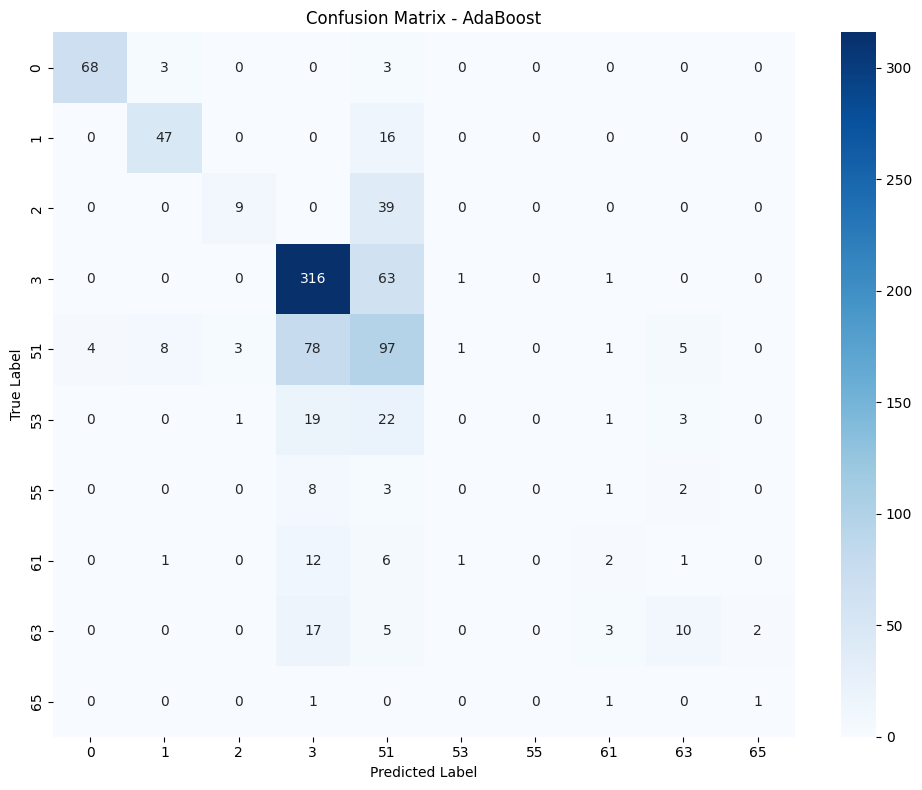


MODEL: Softmax Regression

1. Accuracy: 0.6456
2. Precision (macro): 0.4568
3. Recall (macro): 0.3979
4. F1-Score (macro): 0.4039
5. Cohen's Kappa: 0.4970

6. Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.92      0.79        74
           1       0.58      0.40      0.47        63
           2       0.56      0.29      0.38        48
           3       0.73      0.92      0.82       381
          51       0.49      0.49      0.49       197
          53       0.25      0.04      0.07        46
          55       0.00      0.00      0.00        14
          61       0.32      0.35      0.33        23
          63       0.60      0.24      0.35        37
          65       0.33      0.33      0.33         3

    accuracy                           0.65       886
   macro avg       0.46      0.40      0.40       886
weighted avg       0.60      0.65      0.61       886


7. Confusion Matrix:
[[ 68   6   0   0   0   0   0   0   

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

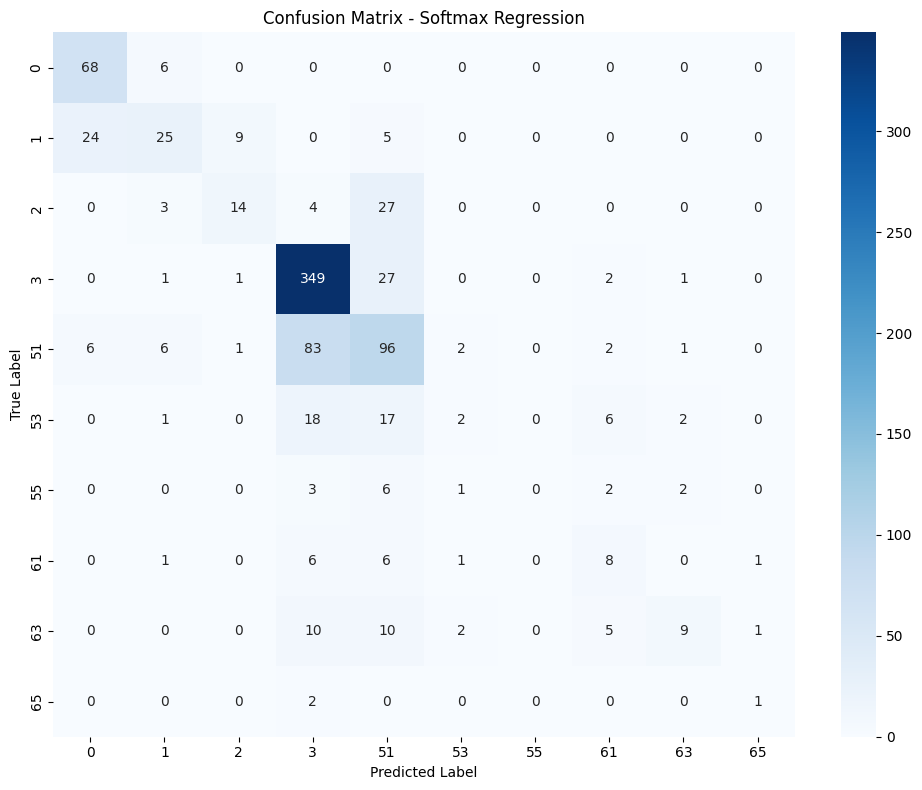


MODEL: Random Forest

1. Accuracy: 0.7562
2. Precision (macro): 0.6624
3. Recall (macro): 0.5684
4. F1-Score (macro): 0.5976
5. Cohen's Kappa: 0.6602

6. Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        74
           1       0.90      0.89      0.90        63
           2       0.84      0.79      0.82        48
           3       0.80      0.93      0.86       381
          51       0.58      0.59      0.59       197
          53       0.53      0.17      0.26        46
          55       0.00      0.00      0.00        14
          61       0.35      0.26      0.30        23
          63       0.67      0.38      0.48        37
          65       1.00      0.67      0.80         3

    accuracy                           0.76       886
   macro avg       0.66      0.57      0.60       886
weighted avg       0.73      0.76      0.73       886


7. Confusion Matrix:
[[ 74   0   0   0   0   0   0   0   0   0

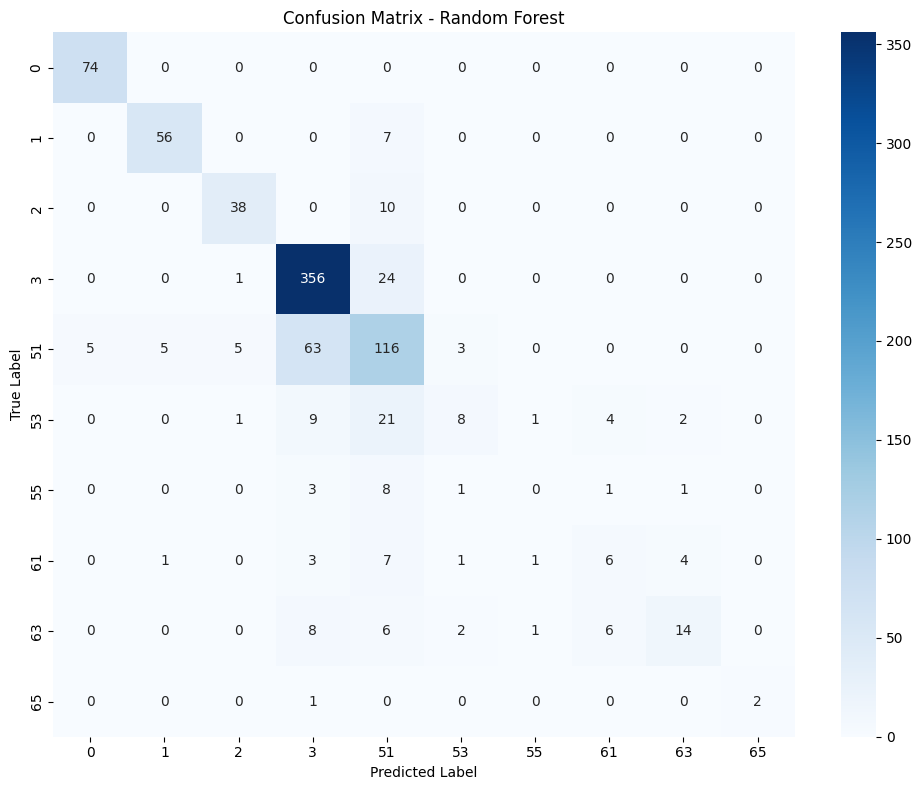

In [41]:
# Đánh giá từng model
print("\n" + "="*60)
print("EVALUATING MODELS ON TEST SET")
print("="*60)

results = []
results.append(evaluate_model(ada_model, X_test, y_test, 'AdaBoost'))
results.append(evaluate_model(softmax_model, X_test, y_test, 'Softmax Regression'))
results.append(evaluate_model(rf_model, X_test, y_test, 'Random Forest'))

In [42]:
# ================== BƯỚC 14: SO SÁNH KẾT QUẢ ==================

# Tạo bảng so sánh
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("\n" + "="*70)
print("COMPARISON TABLE - SORTED BY F1-SCORE")
print("="*70)
print(comparison_df.to_string(index=False))


COMPARISON TABLE - SORTED BY F1-SCORE
             Model  Accuracy  Precision   Recall  F1-Score  Cohen_Kappa
     Random Forest  0.756208   0.662385 0.568360  0.597551     0.660194
Softmax Regression  0.645598   0.456819 0.397861  0.403932     0.497041
          AdaBoost  0.620767   0.452544 0.386479  0.398622     0.460992


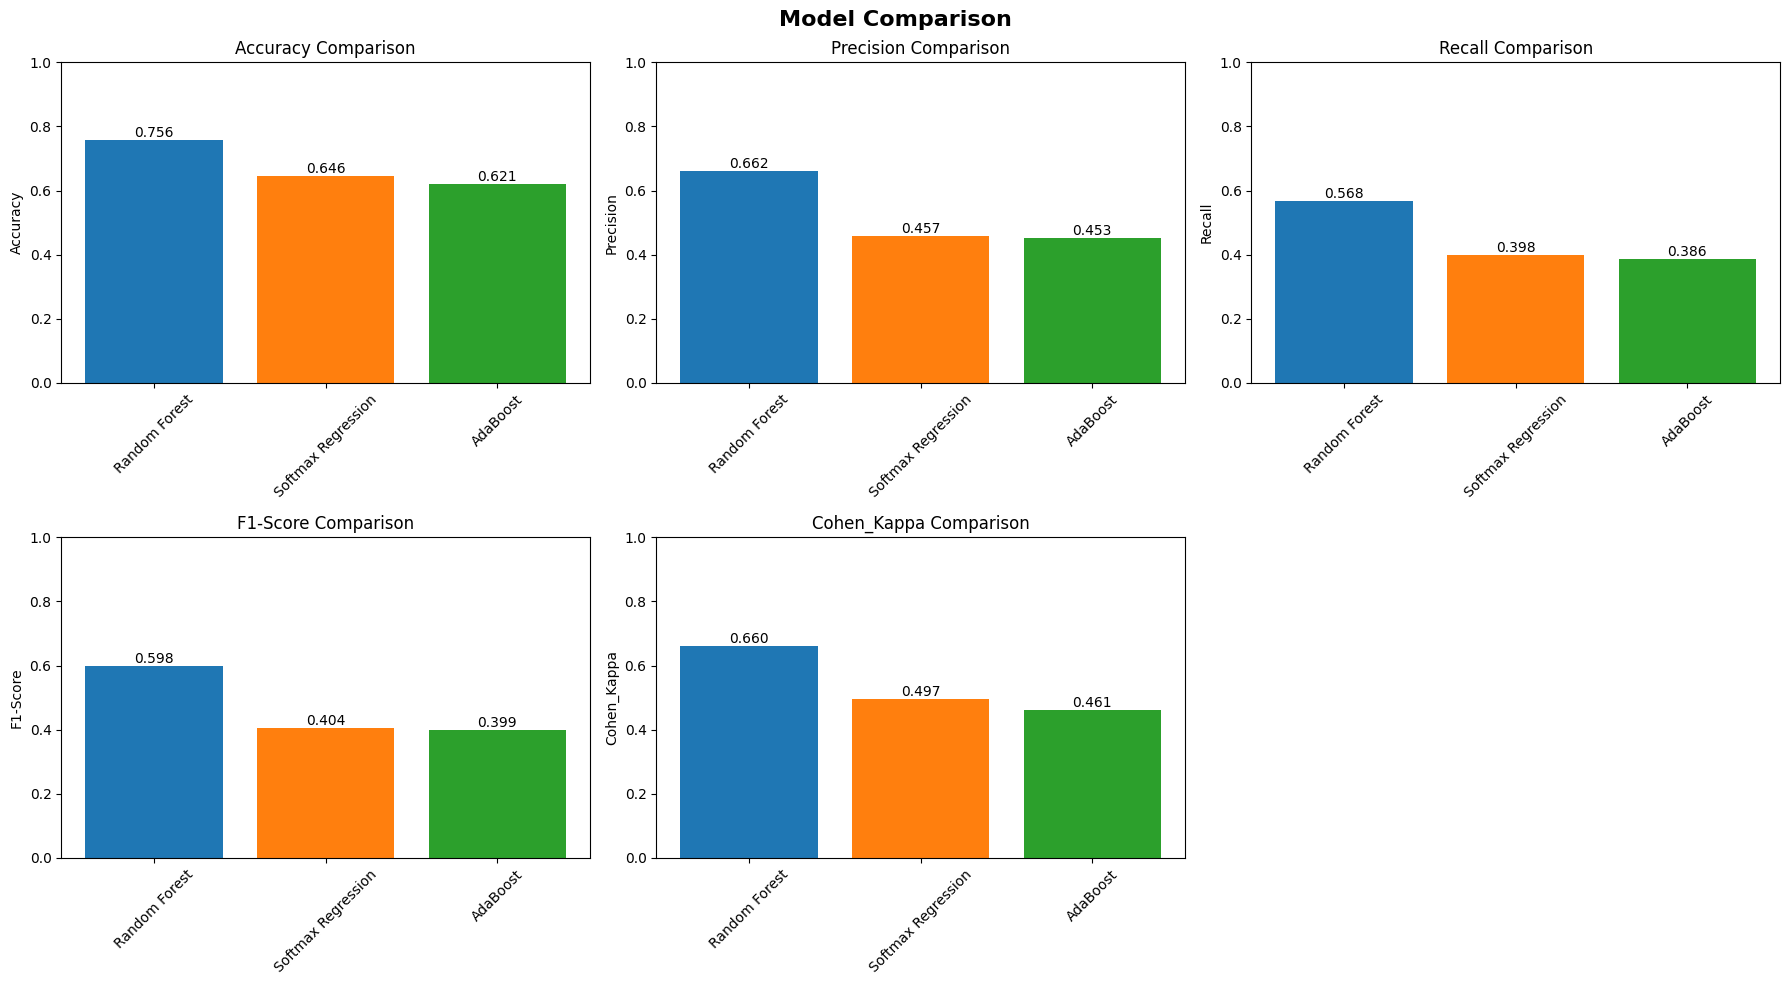


FINAL CONCLUSION

🏆 Best Model: Random Forest
   - F1-Score: 0.5976
   - Accuracy: 0.7562
   - Cohen's Kappa: 0.6602


In [43]:
# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Cohen_Kappa']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, metric in enumerate(metrics):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=colors)
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_ylim([0, 1])
    
    # Thêm giá trị lên đầu mỗi cột
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)
    
    ax.tick_params(axis='x', rotation=45)

# Ẩn subplot thừa
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Tổng kết
print("\n" + "="*70)
print("FINAL CONCLUSION")
print("="*70)
best_model = comparison_df.iloc[0]
print(f"\n🏆 Best Model: {best_model['Model']}")
print(f"   - F1-Score: {best_model['F1-Score']:.4f}")
print(f"   - Accuracy: {best_model['Accuracy']:.4f}")
print(f"   - Cohen's Kappa: {best_model['Cohen_Kappa']:.4f}")